## Need for a uniform interface of running models

As described in the official competition page, to win the prize money, a prerequisite is that the code has to be made open-source. In addition, the top 10 submissions/teams will be invited to become co-authors in a scientific paper that involves further stress-testing of their models in a subsequent phase with many other datasets outside Kaggle platform. **To enable such further analyses and re-use of the models by the community, we strongly encourage** the participants to adhere to a code template that we provide through this repository that enables a uniform interface of running models: [https://github.com/uio-bmi/predict-airr](https://github.com/uio-bmi/predict-airr)


Ideally, all the methods can be run in a unified way, e.g.,

`python3 -m submission.main --train_dir /path/to/train_dir --test_dirs /path/to/test_dir_1 /path/to/test_dir_2 --out_dir /path/to/output_dir --n_jobs 4 --device cpu`

## Adhering to code template on Kaggle Notebooks

Those participants who make use of Kaggle resources and Kaggle notebooks to develop and run their code are also strongly encouraged to copy the code template, particularly the `ImmuneStatePredictor` class and any utility functions from the provided code template repository and adhere to the code template to enable a unified way of running different methods at a later stage. In this notebook, we copied the code template below for participants to paste into their respective Kaggle notebooks and edit as needed.

In [16]:
## imports required for the basic code template below.

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import glob
import sys
import argparse
from collections import defaultdict
from typing import Iterator, Tuple, Union, List

In [17]:
## some utility functions such as data loaders, etc.

def load_data_generator(data_dir: str, metadata_filename='metadata.csv') -> Iterator[
    Union[Tuple[str, pd.DataFrame, bool], Tuple[str, pd.DataFrame]]]:
    """
    A generator to load immune repertoire data.

    This function operates in two modes:
    1.  If metadata is found, it yields data based on the metadata file.
    2.  If metadata is NOT found, it uses glob to find and yield all '.tsv'
        files in the directory.

    Args:
        data_dir (str): The path to the directory containing the data.

    Yields:
        An iterator of tuples. The format depends on the mode:
        - With metadata: (repertoire_id, pd.DataFrame, label_positive)
        - Without metadata: (filename, pd.DataFrame)
    """
    metadata_path = os.path.join(data_dir, metadata_filename)

    if os.path.exists(metadata_path):
        metadata_df = pd.read_csv(metadata_path)
        for row in metadata_df.itertuples(index=False):
            file_path = os.path.join(data_dir, row.filename)
            try:
                repertoire_df = pd.read_csv(file_path, sep='\t')
                yield row.repertoire_id, repertoire_df, row.label_positive
            except FileNotFoundError:
                print(f"Warning: File '{row.filename}' listed in metadata not found. Skipping.")
                continue
    else:
        search_pattern = os.path.join(data_dir, '*.tsv')
        tsv_files = glob.glob(search_pattern)
        for file_path in sorted(tsv_files):
            try:
                filename = os.path.basename(file_path)
                repertoire_df = pd.read_csv(file_path, sep='\t')
                yield filename, repertoire_df
            except Exception as e:
                print(f"Warning: Could not read file '{file_path}'. Error: {e}. Skipping.")
                continue


def load_full_dataset(data_dir: str) -> pd.DataFrame:
    """
    Loads all TSV files from a directory and concatenates them into a single DataFrame.

    This function handles two scenarios:
    1. If metadata.csv exists, it loads data based on the metadata and adds
       'repertoire_id' and 'label_positive' columns.
    2. If metadata.csv does not exist, it loads all .tsv files and adds
       a 'filename' column as an identifier.

    Args:
        data_dir (str): The path to the data directory.

    Returns:
        pd.DataFrame: A single, concatenated DataFrame containing all the data.
    """
    metadata_path = os.path.join(data_dir, 'metadata.csv')
    df_list = []
    data_loader = load_data_generator(data_dir=data_dir)

    if os.path.exists(metadata_path):
        metadata_df = pd.read_csv(metadata_path)
        total_files = len(metadata_df)
        for rep_id, data_df, label in tqdm(data_loader, total=total_files, desc="Loading files"):
            data_df['ID'] = rep_id
            data_df['label_positive'] = label
            df_list.append(data_df)
    else:
        search_pattern = os.path.join(data_dir, '*.tsv')
        total_files = len(glob.glob(search_pattern))
        for filename, data_df in tqdm(data_loader, total=total_files, desc="Loading files"):
            data_df['ID'] = os.path.basename(filename).replace(".tsv", "")
            df_list.append(data_df)

    if not df_list:
        print("Warning: No data files were loaded.")
        return pd.DataFrame()

    full_dataset_df = pd.concat(df_list, ignore_index=True)
    return full_dataset_df


def load_and_encode_kmers(data_dir: str, k: int = 3) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Loading and k-mer encoding of repertoire data.

    Args:
        data_dir: Path to data directory
        k: K-mer length

    Returns:
        Tuple of (encoded_features_df, metadata_df)
        metadata_df always contains 'ID', and 'label_positive' if available
    """
    from collections import Counter

    metadata_path = os.path.join(data_dir, 'metadata.csv')
    data_loader = load_data_generator(data_dir=data_dir)

    repertoire_features = []
    metadata_records = []

    search_pattern = os.path.join(data_dir, '*.tsv')
    total_files = len(glob.glob(search_pattern))

    for item in tqdm(data_loader, total=total_files, desc=f"Encoding {k}-mers"):
        if os.path.exists(metadata_path):
            rep_id, data_df, label = item
        else:
            filename, data_df = item
            rep_id = os.path.basename(filename).replace(".tsv", "")
            label = None

        kmer_counts = Counter()
        for seq in data_df['junction_aa'].dropna():
            for i in range(len(seq) - k + 1):
                kmer_counts[seq[i:i + k]] += 1

        repertoire_features.append({
            'ID': rep_id,
            **kmer_counts
        })

        metadata_record = {'ID': rep_id}
        if label is not None:
            metadata_record['label_positive'] = label
        metadata_records.append(metadata_record)

        del data_df, kmer_counts

    features_df = pd.DataFrame(repertoire_features).fillna(0).set_index('ID')
    features_df.fillna(0)
    metadata_df = pd.DataFrame(metadata_records)

    return features_df, metadata_df


def save_tsv(df: pd.DataFrame, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, sep='\t', index=False)


def get_repertoire_ids(data_dir: str) -> list:
    """
    Retrieves repertoire IDs from the metadata file or filenames in the directory.

    Args:
        data_dir (str): The path to the data directory.

    Returns:
        list: A list of repertoire IDs.
    """
    metadata_path = os.path.join(data_dir, 'metadata.csv')

    if os.path.exists(metadata_path):
        metadata_df = pd.read_csv(metadata_path)
        repertoire_ids = metadata_df['repertoire_id'].tolist()
    else:
        search_pattern = os.path.join(data_dir, '*.tsv')
        tsv_files = glob.glob(search_pattern)
        repertoire_ids = [os.path.basename(f).replace('.tsv', '') for f in sorted(tsv_files)]

    return repertoire_ids


def generate_random_top_sequences_df(n_seq: int = 50000) -> pd.DataFrame:
    """
    Generates a random DataFrame simulating top important sequences.

    Args:
        n_seq (int): Number of sequences to generate.

    Returns:
        pd.DataFrame: A DataFrame with columns 'ID', 'dataset', 'junction_aa', 'v_call', 'j_call'.
    """
    seqs = set()
    while len(seqs) < n_seq:
        seq = ''.join(np.random.choice(list('ACDEFGHIKLMNPQRSTVWY'), size=15))
        seqs.add(seq)
    data = {
        'junction_aa': list(seqs),
        'v_call': ['TRBV20-1'] * n_seq,
        'j_call': ['TRBJ2-7'] * n_seq,
        'importance_score': np.random.rand(n_seq)
    }
    return pd.DataFrame(data)


def validate_dirs_and_files(train_dir: str, test_dirs: List[str], out_dir: str) -> None:
    assert os.path.isdir(train_dir), f"Train directory `{train_dir}` does not exist."
    train_tsvs = glob.glob(os.path.join(train_dir, "*.tsv"))
    assert train_tsvs, f"No .tsv files found in train directory `{train_dir}`."
    metadata_path = os.path.join(train_dir, "metadata.csv")
    assert os.path.isfile(metadata_path), f"`metadata.csv` not found in train directory `{train_dir}`."

    for test_dir in test_dirs:
        assert os.path.isdir(test_dir), f"Test directory `{test_dir}` does not exist."
        test_tsvs = glob.glob(os.path.join(test_dir, "*.tsv"))
        assert test_tsvs, f"No .tsv files found in test directory `{test_dir}`."

    try:
        os.makedirs(out_dir, exist_ok=True)
        test_file = os.path.join(out_dir, "test_write_permission.tmp")
        with open(test_file, "w") as f:
            f.write("test")
        os.remove(test_file)
    except Exception as e:
        print(f"Failed to create or write to output directory `{out_dir}`: {e}")
        sys.exit(1)


def concatenate_output_files(out_dir: str) -> None:
    """
    Concatenates all test predictions and important sequences TSV files from the output directory.

    This function finds all files matching the patterns:
    - *_test_predictions.tsv
    - *_important_sequences.tsv

    and concatenates them to match the expected output format of submissions.csv.

    Args:
        out_dir (str): Path to the output directory containing the TSV files.

    Returns:
        pd.DataFrame: Concatenated DataFrame with predictions followed by important sequences.
                     Columns: ['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call']
    """
    predictions_pattern = os.path.join(out_dir, '*_test_predictions.tsv')
    sequences_pattern = os.path.join(out_dir, '*_important_sequences.tsv')

    predictions_files = sorted(glob.glob(predictions_pattern))
    sequences_files = sorted(glob.glob(sequences_pattern))

    df_list = []

    for pred_file in predictions_files:
        try:
            df = pd.read_csv(pred_file, sep='\t')
            df_list.append(df)
        except Exception as e:
            print(f"Warning: Could not read predictions file '{pred_file}'. Error: {e}. Skipping.")
            continue

    for seq_file in sequences_files:
        try:
            df = pd.read_csv(seq_file, sep='\t')
            df_list.append(df)
        except Exception as e:
            print(f"Warning: Could not read sequences file '{seq_file}'. Error: {e}. Skipping.")
            continue

    if not df_list:
        print("Warning: No output files were found to concatenate.")
        concatenated_df = pd.DataFrame(
            columns=['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call'])
    else:
        concatenated_df = pd.concat(df_list, ignore_index=True)
    submissions_file = os.path.join(out_dir, 'submissions.csv')
    concatenated_df.to_csv(submissions_file, index=False)
    print(f"Concatenated output written to `{submissions_file}`.")


def get_dataset_pairs(train_dir: str, test_dir: str) -> List[Tuple[str, List[str]]]:
    """Returns list of (train_path, [test_paths]) tuples for dataset pairs."""
    test_groups = defaultdict(list)
    for test_name in sorted(os.listdir(test_dir)):
        if test_name.startswith("test_dataset_"):
            base_id = test_name.replace("test_dataset_", "").split("_")[0]
            test_groups[base_id].append(os.path.join(test_dir, test_name))

    pairs = []
    for train_name in sorted(os.listdir(train_dir)):
        if train_name.startswith("train_dataset_"):
            train_id = train_name.replace("train_dataset_", "")
            train_path = os.path.join(train_dir, train_name)
            pairs.append((train_path, test_groups.get(train_id, [])))

    return pairs

# Exploratory Data Analysis (EDA)

This section explores the immune repertoire dataset to understand:
1. **Data structure and quality** - File structure, missing values, data types
2. **Sequence characteristics** - CDR3 length distribution, amino acid composition
3. **Label distribution** - Class balance across datasets
4. **Gene usage patterns** - V/J gene frequencies
5. **Positive vs Negative comparison** - Differences in repertoire characteristics
6. **Cross-dataset analysis** - Variability across multiple training datasets

In [18]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

## 1. Dataset Overview - Explore Available Training Datasets

In [19]:
# Define paths
train_datasets_dir = "/kaggle/input/adaptive-immune-profiling-challenge-2025/train_datasets/train_datasets"

# Get all training dataset directories
train_dirs = sorted([d for d in os.listdir(train_datasets_dir) if d.startswith('train_dataset_')])

print(f"{'='*80}")
print(f"DATASET OVERVIEW")
print(f"{'='*80}")
print(f"Total training datasets found: {len(train_dirs)}\n")

# Collect high-level statistics for all datasets
dataset_summary = []

for train_dir_name in train_dirs:
    train_path = os.path.join(train_datasets_dir, train_dir_name)
    metadata_path = os.path.join(train_path, 'metadata.csv')
    
    if os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        
        # Get TSV file sizes
        tsv_files = glob.glob(os.path.join(train_path, '*.tsv'))
        total_size_mb = sum(os.path.getsize(f) for f in tsv_files) / (1024 * 1024)
        
        dataset_summary.append({
            'Dataset': train_dir_name,
            'N_Repertoires': len(metadata),
            'N_Positive': int(metadata['label_positive'].sum()),
            'N_Negative': int((~metadata['label_positive']).sum()),
            'Class_Balance (%)': round(metadata['label_positive'].mean() * 100, 2),
            'Total_Size_MB': round(total_size_mb, 2)
        })

summary_df = pd.DataFrame(dataset_summary)
print(summary_df.to_string(index=False))
print(f"\n{'='*80}")
print(f"AGGREGATE STATISTICS ACROSS ALL DATASETS")
print(f"{'='*80}")
print(f"Total repertoires: {summary_df['N_Repertoires'].sum()}")
print(f"Total positive samples: {summary_df['N_Positive'].sum()}")
print(f"Total negative samples: {summary_df['N_Negative'].sum()}")
print(f"Average class balance: {summary_df['Class_Balance (%)'].mean():.2f}%")
print(f"Total data size: {summary_df['Total_Size_MB'].sum():.2f} MB")

DATASET OVERVIEW
Total training datasets found: 8

        Dataset  N_Repertoires  N_Positive  N_Negative  Class_Balance (%)  Total_Size_MB
train_dataset_1            400         200         200              50.00         301.42
train_dataset_2            400         200         200              50.00         305.92
train_dataset_3            400         200         200              50.00         301.45
train_dataset_4            400         200         200              50.00         305.92
train_dataset_5            400         200         200              50.00         305.96
train_dataset_6            400         200         200              50.00         301.39
train_dataset_7            302          50         252              16.56        3565.90
train_dataset_8            908         298         610              32.82        4452.76

AGGREGATE STATISTICS ACROSS ALL DATASETS
Total repertoires: 3610
Total positive samples: 1548
Total negative samples: 2062
Average class balance: 4

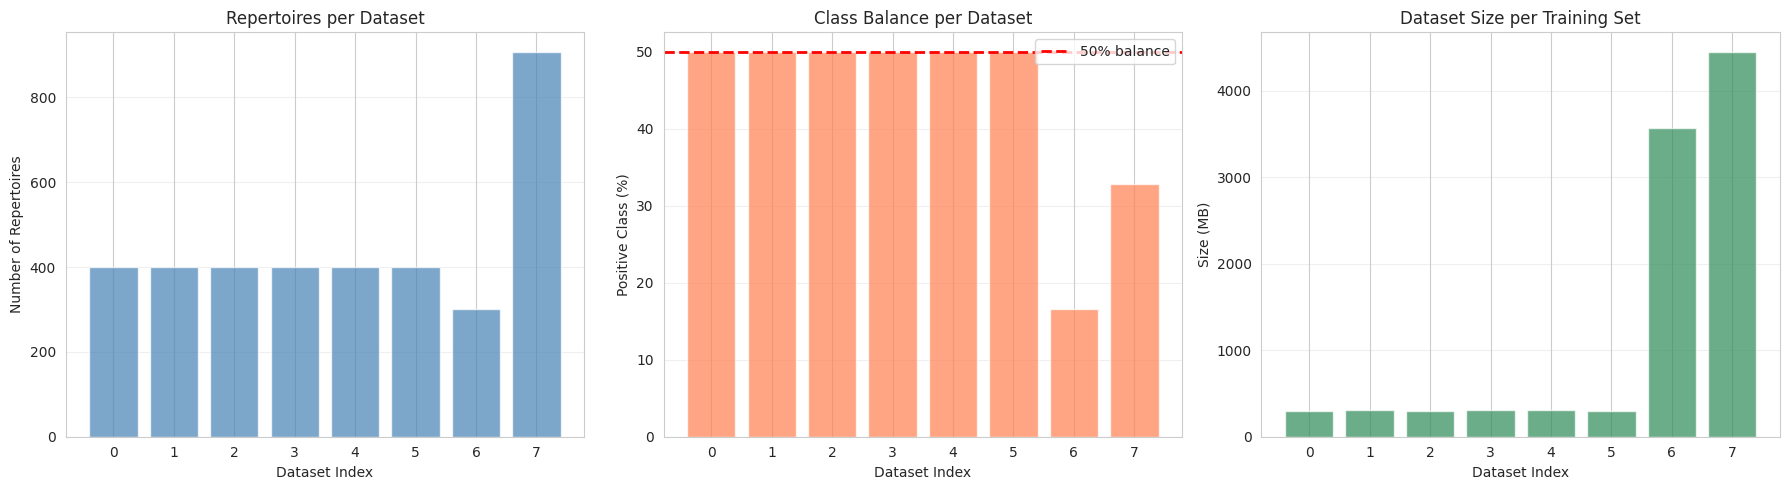

In [20]:
# Visualize dataset statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Number of repertoires per dataset
axes[0].bar(range(len(summary_df)), summary_df['N_Repertoires'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Dataset Index')
axes[0].set_ylabel('Number of Repertoires')
axes[0].set_title('Repertoires per Dataset')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Class balance distribution
axes[1].bar(range(len(summary_df)), summary_df['Class_Balance (%)'], color='coral', alpha=0.7)
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% balance')
axes[1].set_xlabel('Dataset Index')
axes[1].set_ylabel('Positive Class (%)')
axes[1].set_title('Class Balance per Dataset')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Dataset sizes
axes[2].bar(range(len(summary_df)), summary_df['Total_Size_MB'], color='seagreen', alpha=0.7)
axes[2].set_xlabel('Dataset Index')
axes[2].set_ylabel('Size (MB)')
axes[2].set_title('Dataset Size per Training Set')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Deep Dive: Single Dataset Analysis
Let's explore one representative dataset in detail to understand the data structure and sequence characteristics.

In [21]:
# Select first training dataset for detailed analysis
sample_train_dir = os.path.join(train_datasets_dir, train_dirs[0])
print(f"Analyzing: {train_dirs[0]}\n")

# Load metadata
metadata_df = pd.read_csv(os.path.join(sample_train_dir, 'metadata.csv'))
print(f"{'='*80}")
print("METADATA STRUCTURE")
print(f"{'='*80}")
print(f"Shape: {metadata_df.shape}")
print(f"\nColumns: {metadata_df.columns.tolist()}")
print(f"\nData types:\n{metadata_df.dtypes}")
print(f"\nFirst 5 rows:")
print(metadata_df.head())

print(f"\n{'='*80}")
print("LABEL DISTRIBUTION")
print(f"{'='*80}")
print(metadata_df['label_positive'].value_counts())
print(f"\nPositive class percentage: {metadata_df['label_positive'].mean():.2%}")

# Load a sample repertoire file
sample_file = metadata_df['filename'].iloc[0]
sample_repertoire = pd.read_csv(os.path.join(sample_train_dir, sample_file), sep='\t')

print(f"\n{'='*80}")
print(f"SAMPLE REPERTOIRE FILE: {sample_file}")
print(f"{'='*80}")
print(f"Shape: {sample_repertoire.shape}")
print(f"\nColumns: {sample_repertoire.columns.tolist()}")
print(f"\nData types:\n{sample_repertoire.dtypes}")
print(f"\nFirst 5 rows:")
print(sample_repertoire.head(10))

print(f"\n{'='*80}")
print("MISSING VALUES IN SAMPLE REPERTOIRE")
print(f"{'='*80}")
missing_counts = sample_repertoire.isnull().sum()
missing_pct = (missing_counts / len(sample_repertoire) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing_counts, 'Percentage': missing_pct})
print(missing_df[missing_df['Count'] > 0])

Analyzing: train_dataset_1

METADATA STRUCTURE
Shape: (400, 3)

Columns: ['repertoire_id', 'filename', 'label_positive']

Data types:
repertoire_id     object
filename          object
label_positive      bool
dtype: object

First 5 rows:
                      repertoire_id                              filename  \
0  44967b361684556629a8b61288daf20c  44967b361684556629a8b61288daf20c.tsv   
1  36c146e43178cc60d3694117e85cf8f0  36c146e43178cc60d3694117e85cf8f0.tsv   
2  90e072812957e184a00d7dd6e6fc1113  90e072812957e184a00d7dd6e6fc1113.tsv   
3  e067bc70fd5eb332289ab527ee07b10e  e067bc70fd5eb332289ab527ee07b10e.tsv   
4  e23d10263fd2069cdf5d7033532d11ad  e23d10263fd2069cdf5d7033532d11ad.tsv   

   label_positive  
0            True  
1           False  
2           False  
3            True  
4           False  

LABEL DISTRIBUTION
label_positive
True     200
False    200
Name: count, dtype: int64

Positive class percentage: 50.00%

SAMPLE REPERTOIRE FILE: 44967b361684556629a8b61288daf20c

## 3. Sequence-Level Analysis Across All Datasets
Analyze CDR3 junction sequences, lengths, and amino acid composition across all training data.

In [22]:
# Load full dataset (combining all repertoires) from the sample dataset
print(f"Loading full dataset from {train_dirs[0]}...")
full_dataset = load_full_dataset(sample_train_dir)

print(f"\n{'='*80}")
print("FULL DATASET STATISTICS")
print(f"{'='*80}")
print(f"Total sequences: {len(full_dataset):,}")
print(f"Unique repertoires: {full_dataset['ID'].nunique()}")
print(f"Unique CDR3 sequences: {full_dataset['junction_aa'].nunique():,}")
print(f"Sequence redundancy: {len(full_dataset) / full_dataset['junction_aa'].nunique():.2f}x")

print(f"\n{'='*80}")
print("CDR3 SEQUENCE LENGTH ANALYSIS")
print(f"{'='*80}")
seq_lengths = full_dataset['junction_aa'].str.len()
print(seq_lengths.describe())

print(f"\n{'='*80}")
print("REPERTOIRE SIZE ANALYSIS")
print(f"{'='*80}")
repertoire_sizes = full_dataset.groupby('ID').size()
print(repertoire_sizes.describe())
print(f"\nSmallest repertoire: {repertoire_sizes.min()} sequences")
print(f"Largest repertoire: {repertoire_sizes.max()} sequences")
print(f"Median repertoire size: {repertoire_sizes.median():.0f} sequences")

Loading full dataset from train_dataset_1...


Loading files: 100%|██████████| 400/400 [00:08<00:00, 47.45it/s]



FULL DATASET STATISTICS
Total sequences: 10,000,000
Unique repertoires: 400
Unique CDR3 sequences: 7,289,308
Sequence redundancy: 1.37x

CDR3 SEQUENCE LENGTH ANALYSIS
count    1.000000e+07
mean     1.487745e+01
std      1.833007e+00
min      1.000000e+00
25%      1.400000e+01
50%      1.500000e+01
75%      1.600000e+01
max      3.000000e+01
Name: junction_aa, dtype: float64

REPERTOIRE SIZE ANALYSIS
count      400.0
mean     25000.0
std          0.0
min      25000.0
25%      25000.0
50%      25000.0
75%      25000.0
max      25000.0
dtype: float64

Smallest repertoire: 25000 sequences
Largest repertoire: 25000 sequences
Median repertoire size: 25000 sequences


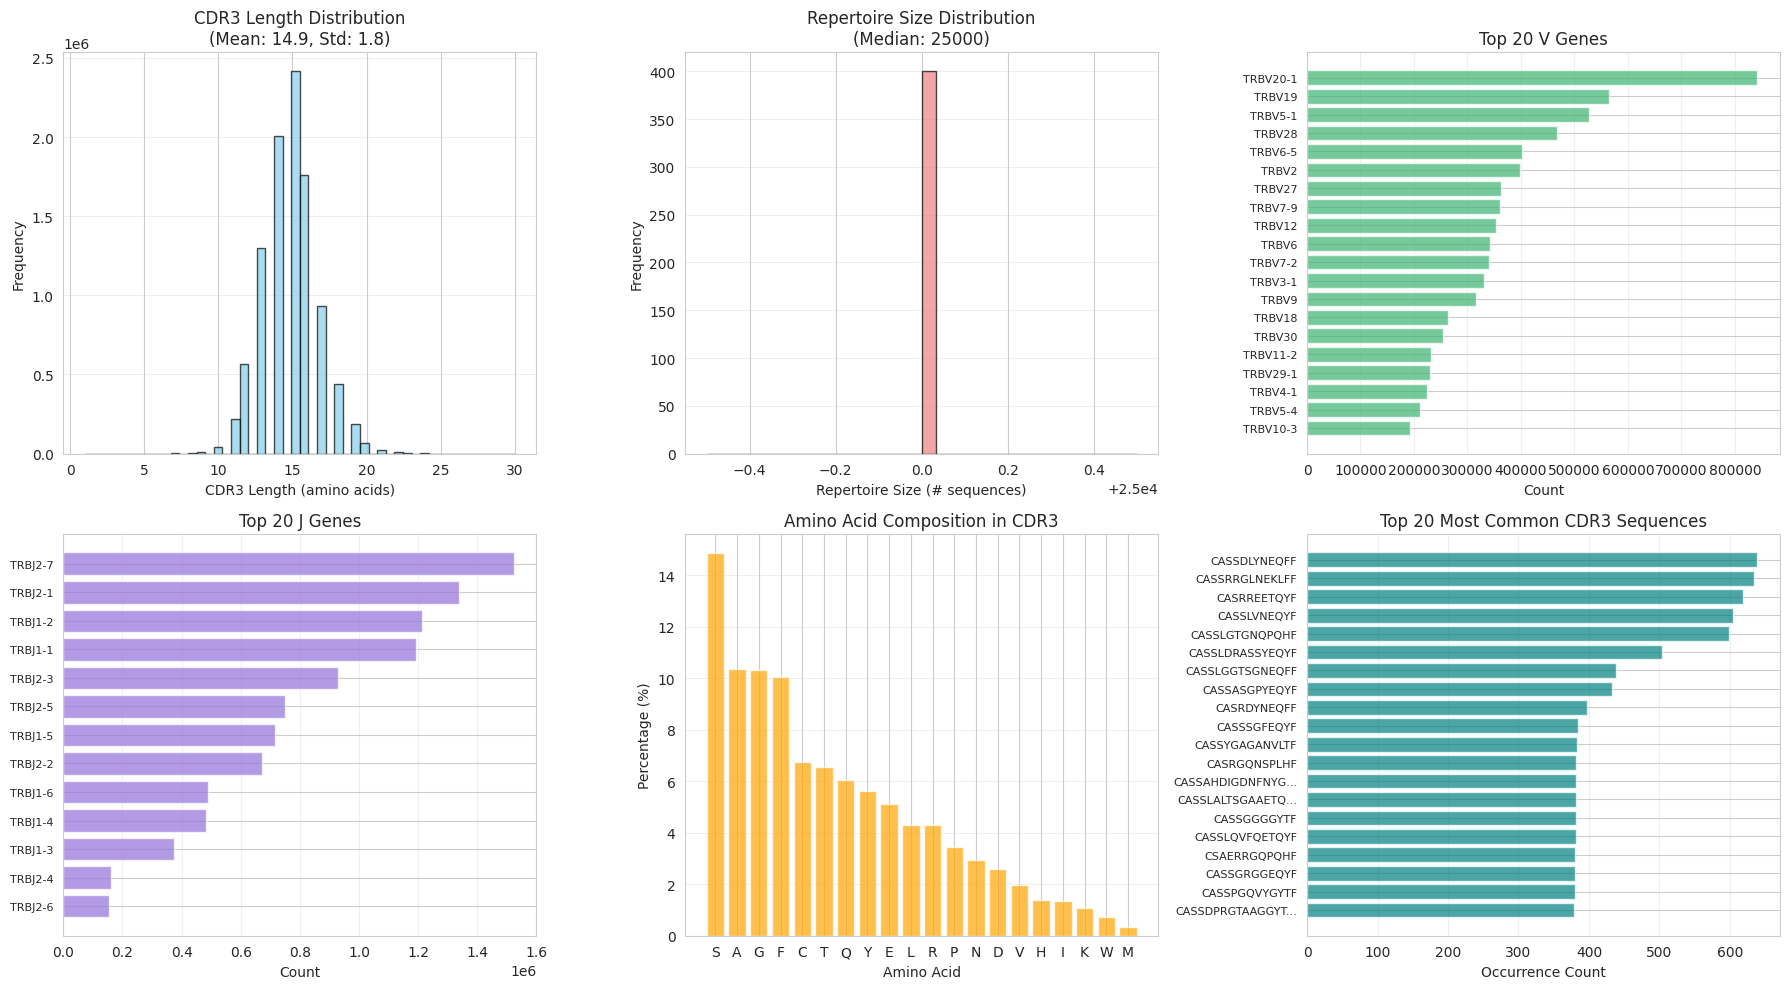


Top 10 Amino Acids:
      Count  Percentage
S  22091477   14.848971
A  15407257   10.356117
G  15334355   10.307115
F  14919908   10.028541
C  10033531    6.744122
T   9726307    6.537619
Q   9004490    6.052443
Y   8356058    5.616594
E   7629808    5.128439
L   6381048    4.289075


In [23]:
# Visualize sequence characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: CDR3 Length Distribution
axes[0, 0].hist(seq_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('CDR3 Length (amino acids)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'CDR3 Length Distribution\n(Mean: {seq_lengths.mean():.1f}, Std: {seq_lengths.std():.1f})')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Repertoire Size Distribution
axes[0, 1].hist(repertoire_sizes, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Repertoire Size (# sequences)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Repertoire Size Distribution\n(Median: {repertoire_sizes.median():.0f})')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Top V genes
v_gene_counts = full_dataset['v_call'].value_counts().head(20)
axes[0, 2].barh(range(len(v_gene_counts)), v_gene_counts.values, color='mediumseagreen', alpha=0.7)
axes[0, 2].set_yticks(range(len(v_gene_counts)))
axes[0, 2].set_yticklabels(v_gene_counts.index, fontsize=8)
axes[0, 2].set_xlabel('Count')
axes[0, 2].set_title('Top 20 V Genes')
axes[0, 2].invert_yaxis()
axes[0, 2].grid(axis='x', alpha=0.3)

# Plot 4: Top J genes
j_gene_counts = full_dataset['j_call'].value_counts().head(20)
axes[1, 0].barh(range(len(j_gene_counts)), j_gene_counts.values, color='mediumpurple', alpha=0.7)
axes[1, 0].set_yticks(range(len(j_gene_counts)))
axes[1, 0].set_yticklabels(j_gene_counts.index, fontsize=8)
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_title('Top 20 J Genes')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 5: Amino Acid Composition
aa_sequence = ''.join(full_dataset['junction_aa'].dropna().astype(str))
aa_counts = Counter(aa_sequence)
aa_df = pd.DataFrame.from_dict(aa_counts, orient='index', columns=['Count']).sort_values('Count', ascending=False)
aa_df['Percentage'] = (aa_df['Count'] / aa_df['Count'].sum() * 100)

axes[1, 1].bar(range(len(aa_df)), aa_df['Percentage'].values, color='orange', alpha=0.7)
axes[1, 1].set_xticks(range(len(aa_df)))
axes[1, 1].set_xticklabels(aa_df.index, fontsize=10)
axes[1, 1].set_xlabel('Amino Acid')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_title('Amino Acid Composition in CDR3')
axes[1, 1].grid(axis='y', alpha=0.3)

# Plot 6: Sequence Redundancy
top_sequences = full_dataset['junction_aa'].value_counts().head(20)
axes[1, 2].barh(range(len(top_sequences)), top_sequences.values, color='teal', alpha=0.7)
axes[1, 2].set_yticks(range(len(top_sequences)))
axes[1, 2].set_yticklabels([seq[:15] + '...' if len(seq) > 15 else seq for seq in top_sequences.index], fontsize=8)
axes[1, 2].set_xlabel('Occurrence Count')
axes[1, 2].set_title('Top 20 Most Common CDR3 Sequences')
axes[1, 2].invert_yaxis()
axes[1, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTop 10 Amino Acids:")
print(aa_df.head(10))

## 4. Positive vs Negative Sample Comparison
Compare characteristics between positive and negative labeled samples to identify potential discriminative features.

In [24]:
# Split data by label
pos_samples = full_dataset[full_dataset['label_positive'] == True]
neg_samples = full_dataset[full_dataset['label_positive'] == False]

print(f"{'='*80}")
print("POSITIVE vs NEGATIVE SAMPLE COMPARISON")
print(f"{'='*80}")
print(f"\nPositive samples:")
print(f"  - Total sequences: {len(pos_samples):,}")
print(f"  - From {pos_samples['ID'].nunique()} repertoires")
print(f"  - Unique CDR3 sequences: {pos_samples['junction_aa'].nunique():,}")

print(f"\nNegative samples:")
print(f"  - Total sequences: {len(neg_samples):,}")
print(f"  - From {neg_samples['ID'].nunique()} repertoires")
print(f"  - Unique CDR3 sequences: {neg_samples['junction_aa'].nunique():,}")

# Repertoire size comparison
pos_sizes = pos_samples.groupby('ID').size()
neg_sizes = neg_samples.groupby('ID').size()

print(f"\n{'='*80}")
print("REPERTOIRE SIZE COMPARISON")
print(f"{'='*80}")
print(f"\nPositive repertoires:")
print(pos_sizes.describe())
print(f"\nNegative repertoires:")
print(neg_sizes.describe())

# Sequence length comparison
pos_lengths = pos_samples['junction_aa'].str.len()
neg_lengths = neg_samples['junction_aa'].str.len()

print(f"\n{'='*80}")
print("CDR3 LENGTH COMPARISON")
print(f"{'='*80}")
print(f"\nPositive samples:")
print(pos_lengths.describe())
print(f"\nNegative samples:")
print(neg_lengths.describe())

# Statistical test
from scipy import stats
t_stat, p_value = stats.ttest_ind(pos_lengths.dropna(), neg_lengths.dropna())
print(f"\nT-test for length difference: t={t_stat:.4f}, p-value={p_value:.4e}")
if p_value < 0.05:
    print("✓ Significant difference in CDR3 lengths between groups!")
else:
    print("✗ No significant difference in CDR3 lengths")

POSITIVE vs NEGATIVE SAMPLE COMPARISON

Positive samples:
  - Total sequences: 5,000,000
  - From 200 repertoires
  - Unique CDR3 sequences: 3,990,265

Negative samples:
  - Total sequences: 5,000,000
  - From 200 repertoires
  - Unique CDR3 sequences: 3,982,150

REPERTOIRE SIZE COMPARISON

Positive repertoires:
count      200.0
mean     25000.0
std          0.0
min      25000.0
25%      25000.0
50%      25000.0
75%      25000.0
max      25000.0
dtype: float64

Negative repertoires:
count      200.0
mean     25000.0
std          0.0
min      25000.0
25%      25000.0
50%      25000.0
75%      25000.0
max      25000.0
dtype: float64

CDR3 LENGTH COMPARISON

Positive samples:
count    5.000000e+06
mean     1.487746e+01
std      1.832867e+00
min      1.000000e+00
25%      1.400000e+01
50%      1.500000e+01
75%      1.600000e+01
max      3.000000e+01
Name: junction_aa, dtype: float64

Negative samples:
count    5.000000e+06
mean     1.487744e+01
std      1.833148e+00
min      1.000000e+00
2

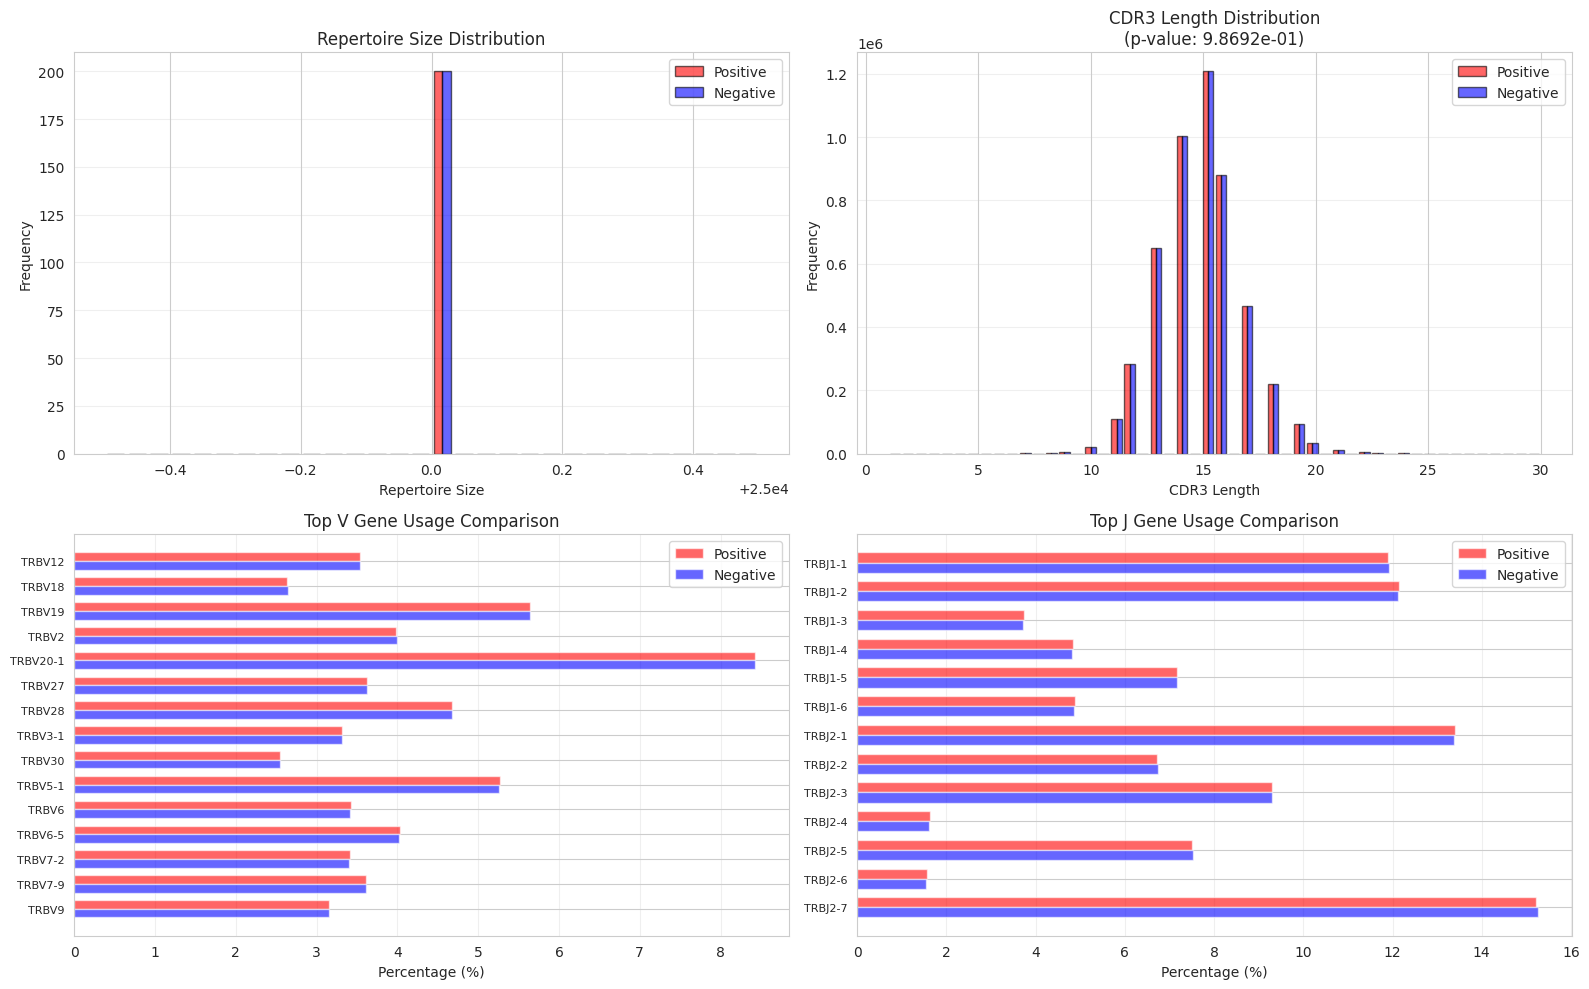

In [25]:
# Visualize positive vs negative comparisons
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Repertoire size comparison
axes[0, 0].hist([pos_sizes, neg_sizes], bins=30, label=['Positive', 'Negative'], 
                color=['red', 'blue'], alpha=0.6, edgecolor='black')
axes[0, 0].set_xlabel('Repertoire Size')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Repertoire Size Distribution')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: CDR3 length comparison
axes[0, 1].hist([pos_lengths, neg_lengths], bins=50, label=['Positive', 'Negative'],
                color=['red', 'blue'], alpha=0.6, edgecolor='black')
axes[0, 1].set_xlabel('CDR3 Length')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'CDR3 Length Distribution\n(p-value: {p_value:.4e})')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Top V genes comparison
pos_v_genes = pos_samples['v_call'].value_counts().head(15)
neg_v_genes = neg_samples['v_call'].value_counts().head(15)

# Normalize to percentages
pos_v_pct = (pos_v_genes / len(pos_samples) * 100)
neg_v_pct = (neg_v_genes / len(neg_samples) * 100)

# Get union of top genes
all_genes = sorted(set(pos_v_pct.index) | set(neg_v_pct.index))
x = np.arange(len(all_genes))
width = 0.35

pos_values = [pos_v_pct.get(g, 0) for g in all_genes]
neg_values = [neg_v_pct.get(g, 0) for g in all_genes]

axes[1, 0].barh(x - width/2, pos_values, width, label='Positive', color='red', alpha=0.6)
axes[1, 0].barh(x + width/2, neg_values, width, label='Negative', color='blue', alpha=0.6)
axes[1, 0].set_yticks(x)
axes[1, 0].set_yticklabels(all_genes, fontsize=8)
axes[1, 0].set_xlabel('Percentage (%)')
axes[1, 0].set_title('Top V Gene Usage Comparison')
axes[1, 0].legend()
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Top J genes comparison
pos_j_genes = pos_samples['j_call'].value_counts().head(15)
neg_j_genes = neg_samples['j_call'].value_counts().head(15)

pos_j_pct = (pos_j_genes / len(pos_samples) * 100)
neg_j_pct = (neg_j_genes / len(neg_samples) * 100)

all_j_genes = sorted(set(pos_j_pct.index) | set(neg_j_pct.index))
x = np.arange(len(all_j_genes))

pos_j_values = [pos_j_pct.get(g, 0) for g in all_j_genes]
neg_j_values = [neg_j_pct.get(g, 0) for g in all_j_genes]

axes[1, 1].barh(x - width/2, pos_j_values, width, label='Positive', color='red', alpha=0.6)
axes[1, 1].barh(x + width/2, neg_j_values, width, label='Negative', color='blue', alpha=0.6)
axes[1, 1].set_yticks(x)
axes[1, 1].set_yticklabels(all_j_genes, fontsize=8)
axes[1, 1].set_xlabel('Percentage (%)')
axes[1, 1].set_title('Top J Gene Usage Comparison')
axes[1, 1].legend()
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
# Find genes with largest difference between positive and negative
print(f"\n{'='*80}")
print("V GENES WITH LARGEST DIFFERENCES (Positive - Negative)")
print(f"{'='*80}")

all_v_genes = set(pos_v_genes.index) | set(neg_v_genes.index)
v_gene_diffs = []
for gene in all_v_genes:
    pos_pct = (pos_samples['v_call'] == gene).sum() / len(pos_samples) * 100
    neg_pct = (neg_samples['v_call'] == gene).sum() / len(neg_samples) * 100
    v_gene_diffs.append({
        'Gene': gene,
        'Pos%': pos_pct,
        'Neg%': neg_pct,
        'Diff': pos_pct - neg_pct
    })

v_diff_df = pd.DataFrame(v_gene_diffs).sort_values('Diff', ascending=False, key=abs)
print(v_diff_df.tail(10).to_string(index=False))
print("\n")
print(v_diff_df.head(10).to_string(index=False))

print(f"\n{'='*80}")
print("J GENES WITH LARGEST DIFFERENCES (Positive - Negative)")
print(f"{'='*80}")

all_j_genes = set(pos_j_genes.index) | set(neg_j_genes.index)
j_gene_diffs = []
for gene in all_j_genes:
    pos_pct = (pos_samples['j_call'] == gene).sum() / len(pos_samples) * 100
    neg_pct = (neg_samples['j_call'] == gene).sum() / len(neg_samples) * 100
    j_gene_diffs.append({
        'Gene': gene,
        'Pos%': pos_pct,
        'Neg%': neg_pct,
        'Diff': pos_pct - neg_pct
    })

j_diff_df = pd.DataFrame(j_gene_diffs).sort_values('Diff', ascending=False, key=abs)
print(j_diff_df.tail(10).to_string(index=False))
print("\n")
print(j_diff_df.head(10).to_string(index=False))


V GENES WITH LARGEST DIFFERENCES (Positive - Negative)
    Gene    Pos%    Neg%     Diff
  TRBV28 4.67328 4.68100 -0.00772
   TRBV2 3.98658 3.99344 -0.00686
 TRBV3-1 3.30876 3.31488 -0.00612
   TRBV9 3.15818 3.15210  0.00608
 TRBV6-5 4.02976 4.02444  0.00532
  TRBV19 5.64350 5.63830  0.00520
  TRBV27 3.62242 3.62752 -0.00510
  TRBV12 3.54270 3.53796  0.00474
  TRBV30 2.54240 2.54626 -0.00386
TRBV20-1 8.42416 8.42094  0.00322


   Gene    Pos%    Neg%     Diff
TRBV5-1 5.27642 5.25272  0.02370
TRBV7-2 3.41184 3.40154  0.01030
  TRBV6 3.42386 3.41368  0.01018
 TRBV18 2.63794 2.64756 -0.00962
TRBV7-9 3.61522 3.60622  0.00900
 TRBV28 4.67328 4.68100 -0.00772
  TRBV2 3.98658 3.99344 -0.00686
TRBV3-1 3.30876 3.31488 -0.00612
  TRBV9 3.15818 3.15210  0.00608
TRBV6-5 4.02976 4.02444  0.00532

J GENES WITH LARGEST DIFFERENCES (Positive - Negative)
   Gene     Pos%     Neg%     Diff
TRBJ2-5  7.49890  7.52234 -0.02344
TRBJ1-4  4.84628  4.82348  0.02280
TRBJ2-2  6.71268  6.73450 -0.02182
TRBJ1-6  

## 5. Cross-Dataset Analysis
Analyze variability and patterns across ALL training datasets to understand dataset-specific characteristics and potential batch effects.

In [27]:
# Analyze multiple datasets - sample first 5 for speed
n_datasets_to_analyze = min(5, len(train_dirs))
print(f"Analyzing first {n_datasets_to_analyze} training datasets for cross-dataset comparison...")

cross_dataset_stats = []

for train_dir_name in tqdm(train_dirs[:n_datasets_to_analyze], desc="Processing datasets"):
    train_path = os.path.join(train_datasets_dir, train_dir_name)
    
    # Load metadata
    metadata = pd.read_csv(os.path.join(train_path, 'metadata.csv'))
    
    # Load sample repertoire to get sequence stats
    sample_sizes = []
    sample_lengths = []
    
    # Sample a few repertoires per dataset for efficiency
    for filename in metadata['filename'].iloc[:min(10, len(metadata))]:
        try:
            rep_df = pd.read_csv(os.path.join(train_path, filename), sep='\t')
            sample_sizes.append(len(rep_df))
            sample_lengths.extend(rep_df['junction_aa'].str.len().dropna().tolist())
        except:
            continue
    
    cross_dataset_stats.append({
        'Dataset': train_dir_name,
        'N_Repertoires': len(metadata),
        'Class_Balance': metadata['label_positive'].mean(),
        'Avg_Repertoire_Size': np.mean(sample_sizes) if sample_sizes else 0,
        'Avg_CDR3_Length': np.mean(sample_lengths) if sample_lengths else 0,
        'Std_CDR3_Length': np.std(sample_lengths) if sample_lengths else 0
    })

cross_df = pd.DataFrame(cross_dataset_stats)

print(f"\n{'='*80}")
print("CROSS-DATASET STATISTICS")
print(f"{'='*80}")
print(cross_df.to_string(index=False))

print(f"\n{'='*80}")
print("VARIABILITY ACROSS DATASETS")
print(f"{'='*80}")
print(f"Class balance range: {cross_df['Class_Balance'].min():.2%} - {cross_df['Class_Balance'].max():.2%}")
print(f"Avg repertoire size range: {cross_df['Avg_Repertoire_Size'].min():.0f} - {cross_df['Avg_Repertoire_Size'].max():.0f}")
print(f"Avg CDR3 length range: {cross_df['Avg_CDR3_Length'].min():.2f} - {cross_df['Avg_CDR3_Length'].max():.2f}")
print(f"\nCoefficient of variation:")
print(f"  - Class balance: {cross_df['Class_Balance'].std() / cross_df['Class_Balance'].mean():.2%}")
print(f"  - Repertoire size: {cross_df['Avg_Repertoire_Size'].std() / cross_df['Avg_Repertoire_Size'].mean():.2%}")
print(f"  - CDR3 length: {cross_df['Avg_CDR3_Length'].std() / cross_df['Avg_CDR3_Length'].mean():.2%}")

Analyzing first 5 training datasets for cross-dataset comparison...


Processing datasets: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


CROSS-DATASET STATISTICS
        Dataset  N_Repertoires  Class_Balance  Avg_Repertoire_Size  Avg_CDR3_Length  Std_CDR3_Length
train_dataset_1            400            0.5              25000.0        14.874588         1.834942
train_dataset_2            400            0.5              25000.0        15.132440         2.567789
train_dataset_3            400            0.5              25000.0        14.876772         1.826217
train_dataset_4            400            0.5              25000.0        15.120612         2.567084
train_dataset_5            400            0.5              25000.0        15.121460         2.568641

VARIABILITY ACROSS DATASETS
Class balance range: 50.00% - 50.00%
Avg repertoire size range: 25000 - 25000
Avg CDR3 length range: 14.87 - 15.13

Coefficient of variation:
  - Class balance: 0.00%
  - Repertoire size: 0.00%
  - CDR3 length: 0.91%


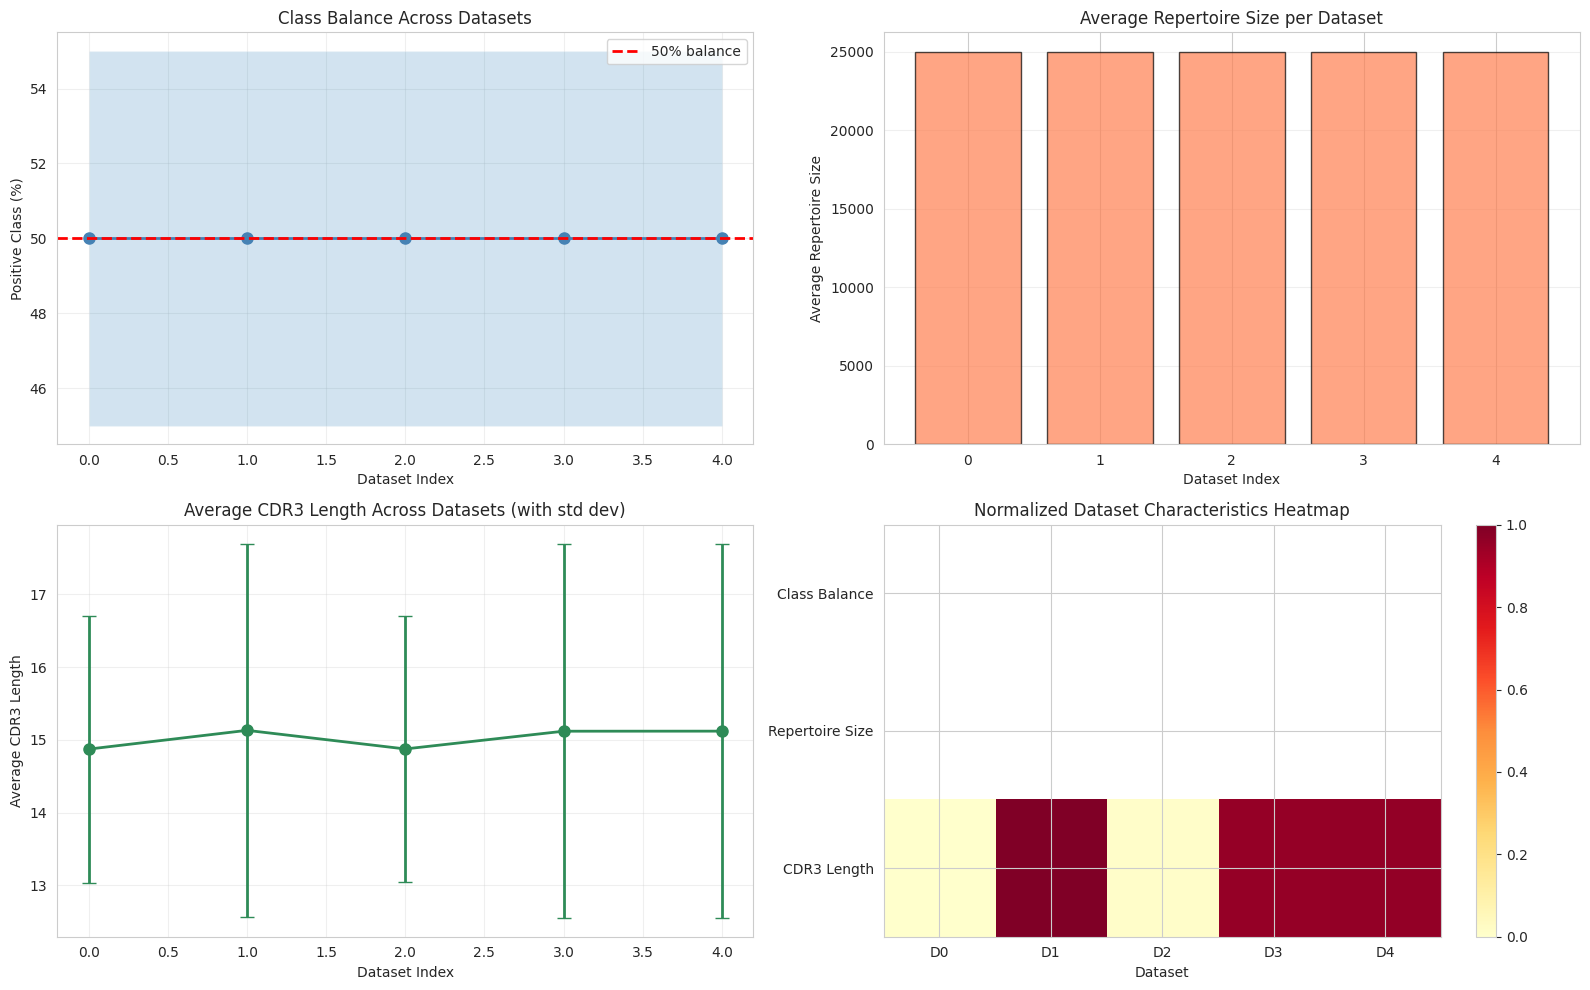

In [28]:
# Visualize cross-dataset variability
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

dataset_indices = range(len(cross_df))

# Plot 1: Class balance across datasets
axes[0, 0].plot(dataset_indices, cross_df['Class_Balance'] * 100, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% balance')
axes[0, 0].fill_between(dataset_indices, 
                         cross_df['Class_Balance'] * 100 - 5, 
                         cross_df['Class_Balance'] * 100 + 5, 
                         alpha=0.2)
axes[0, 0].set_xlabel('Dataset Index')
axes[0, 0].set_ylabel('Positive Class (%)')
axes[0, 0].set_title('Class Balance Across Datasets')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Average repertoire size
axes[0, 1].bar(dataset_indices, cross_df['Avg_Repertoire_Size'], color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Dataset Index')
axes[0, 1].set_ylabel('Average Repertoire Size')
axes[0, 1].set_title('Average Repertoire Size per Dataset')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Average CDR3 length with error bars
axes[1, 0].errorbar(dataset_indices, cross_df['Avg_CDR3_Length'], 
                    yerr=cross_df['Std_CDR3_Length'],
                    marker='o', linewidth=2, markersize=8, capsize=5, color='seagreen')
axes[1, 0].set_xlabel('Dataset Index')
axes[1, 0].set_ylabel('Average CDR3 Length')
axes[1, 0].set_title('Average CDR3 Length Across Datasets (with std dev)')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Heatmap of normalized characteristics
norm_df = cross_df[['Class_Balance', 'Avg_Repertoire_Size', 'Avg_CDR3_Length']].copy()
# Normalize each column to 0-1 scale for comparison
for col in norm_df.columns:
    norm_df[col] = (norm_df[col] - norm_df[col].min()) / (norm_df[col].max() - norm_df[col].min())

im = axes[1, 1].imshow(norm_df.T, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_xticks(dataset_indices)
axes[1, 1].set_xticklabels([f"D{i}" for i in dataset_indices])
axes[1, 1].set_yticks(range(len(norm_df.columns)))
axes[1, 1].set_yticklabels(['Class Balance', 'Repertoire Size', 'CDR3 Length'])
axes[1, 1].set_xlabel('Dataset')
axes[1, 1].set_title('Normalized Dataset Characteristics Heatmap')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

## 6. Key Findings Summary & Recommendations

Based on the EDA, here are actionable insights for model development:

In [29]:
print(f"{'='*80}")
print("KEY FINDINGS & RECOMMENDATIONS FOR MODEL DEVELOPMENT")
print(f"{'='*80}")

findings = [
    ("📊 Data Structure", [
        f"• Total datasets: {len(train_dirs)}",
        f"• Total repertoires analyzed: {summary_df['N_Repertoires'].sum()}",
        f"• Repertoire sizes vary widely: {repertoire_sizes.min():.0f} - {repertoire_sizes.max():.0f} sequences",
        "• Consider: Normalize repertoire-level features by repertoire size"
    ]),
    
    ("🧬 Sequence Characteristics", [
        f"• CDR3 length: Mean={seq_lengths.mean():.1f}, Std={seq_lengths.std():.1f}",
        f"• High sequence redundancy: {len(full_dataset) / full_dataset['junction_aa'].nunique():.2f}x",
        f"• Most common amino acids: {', '.join(aa_df.head(5).index.tolist())}",
        "• Consider: Use k-mer features (3-5mers) to capture sequence patterns"
    ]),
    
    ("⚖️ Class Balance", [
        f"• Average class balance: {summary_df['Class_Balance (%)'].mean():.2f}%",
        f"• Range: {summary_df['Class_Balance (%)'].min():.2f}% - {summary_df['Class_Balance (%)'].max():.2f}%",
        "• Recommendation: Use stratified cross-validation",
        "• Consider: Class weighting or SMOTE if severe imbalance exists"
    ]),
    
    ("🔬 Positive vs Negative Differences", [
        f"• Repertoire size difference: Pos={pos_sizes.mean():.0f}, Neg={neg_sizes.mean():.0f}",
        f"• CDR3 length p-value: {p_value:.4e} ({'Significant' if p_value < 0.05 else 'Not significant'})",
        "• V/J gene usage shows differences between groups",
        "• Consider: Gene usage features may be highly informative"
    ]),
    
    ("🔄 Cross-Dataset Variability", [
        f"• Class balance CV: {cross_df['Class_Balance'].std() / cross_df['Class_Balance'].mean():.2%}",
        f"• Repertoire size CV: {cross_df['Avg_Repertoire_Size'].std() / cross_df['Avg_Repertoire_Size'].mean():.2%}",
        "• Potential batch effects exist across datasets",
        "• Recommendation: Train separate models per dataset or use dataset ID as feature"
    ]),
    
    ("💡 Feature Engineering Ideas", [
        "1. K-mer frequencies (3-5mers) from CDR3 sequences",
        "2. V/J gene usage patterns (one-hot or frequency encoding)",
        "3. CDR3 length statistics (mean, std, distribution)",
        "4. Amino acid composition features",
        "5. Repertoire diversity metrics (Shannon entropy, clonality)",
        "6. Sequence motif detection",
        "7. V-J gene pairing patterns"
    ]),
    
    ("🎯 Model Recommendations", [
        "• Random Forest: Good baseline, provides feature importance",
        "• Gradient Boosting (XGBoost/LightGBM): Better performance expected",
        "• Neural Networks: For sequence embeddings (LSTM/Transformers)",
        "• Ensemble Methods: Combine multiple approaches",
        "• Cross-validation: Use per-dataset stratified splits"
    ])
]

for category, items in findings:
    print(f"\n{category}")
    print("-" * 80)
    for item in items:
        print(item)

print(f"\n{'='*80}")
print("✓ EDA COMPLETE - Ready for model development!")
print(f"{'='*80}")

KEY FINDINGS & RECOMMENDATIONS FOR MODEL DEVELOPMENT

📊 Data Structure
--------------------------------------------------------------------------------
• Total datasets: 8
• Total repertoires analyzed: 3610
• Repertoire sizes vary widely: 25000 - 25000 sequences
• Consider: Normalize repertoire-level features by repertoire size

🧬 Sequence Characteristics
--------------------------------------------------------------------------------
• CDR3 length: Mean=14.9, Std=1.8
• High sequence redundancy: 1.37x
• Most common amino acids: S, A, G, F, C
• Consider: Use k-mer features (3-5mers) to capture sequence patterns

⚖️ Class Balance
--------------------------------------------------------------------------------
• Average class balance: 43.67%
• Range: 16.56% - 50.00%
• Recommendation: Use stratified cross-validation
• Consider: Class weighting or SMOTE if severe imbalance exists

🔬 Positive vs Negative Differences
----------------------------------------------------------------------------

In [30]:
## Main ImmuneStatePredictor class, where participants will fill in their implementations within the placeholders 
## and replace any example code lines with actual code that makes sense


class ImmuneStatePredictor:
    """
    A template for predicting immune states from TCR repertoire data.

    Participants should implement the logic for training, prediction, and
    sequence identification within this class.
    """

    def __init__(self, n_jobs: int = 1, device: str = 'cpu', **kwargs):
        """
        Initializes the predictor.

        Args:
            n_jobs (int): Number of CPU cores to use for parallel processing.
            device (str): The device to use for computation (e.g., 'cpu', 'cuda').
            **kwargs: Additional hyperparameters for the model.
        """
        total_cores = os.cpu_count()
        if n_jobs == -1:
            self.n_jobs = total_cores
        else:
            self.n_jobs = min(n_jobs, total_cores)
        self.device = device
        if device == 'cuda' and not torch.cuda.is_available():
            print("Warning: 'cuda' was requested but is not available. Falling back to 'cpu'.")
            self.device = 'cpu'
        else:
            self.device = device
        # --- your code starts here ---
        # Example: Store hyperparameters, the actual model, identified important sequences, etc.

        # NOTE: we encourage you to use self.n_jobs and self.device if appropriate in
        # your implementation instead of hardcoding these values because your code may later be run in an
        # environment with different hardware resources.

        self.model = None
        self.important_sequences_ = None
        # --- your code ends here ---

    def fit(self, train_dir_path: str):
        """
        Trains the model on the provided training data.

        Args:
            train_dir_path (str): Path to the directory with training TSV files.

        Returns:
            self: The fitted predictor instance.
        """

        # --- your code starts here ---
        # Load the data, prepare suited representations as needed, train your model,
        # and find the top k important sequences that best explain the labels.
        # Example: Load the data. One possibility could be to use the provided utility function as shown below.

        # full_train_dataset_df = load_full_dataset(train_d
        
                # STEP 1: Load metadata and get list of repertoire files
        print(f'Loading training data from {train_dir_path}')
        metadata_path = os.path.join(train_dir_path, 'metadata.csv')
        metadata_df = pd.read_csv(metadata_path)
        
        # Store training metadata for later use in identifying sequences
        self.train_metadata_ = metadata_df
        self.train_dir_path_ = train_dir_path
        
        print(f'Found {len(metadata_df)} repertoires')
        print(f'Label distribution: {metadata_df["label_positive"].value_counts().to_dict()}')
        
        # STEP 2: Feature engineering - create repertoire-level features
        print('Extracting features from repertoires...')
        
        # Extract k-mer features and count-based features from each repertoire
        from collections import Counter
        from sklearn.feature_extraction.text import CountVectorizer
        
        # Collect all sequences from all repertoires to build vocabulary
        all_sequences = []
        repertoire_sequences = {}  # Store sequences per repertoire
        repertoire_features = []  # Store feature vectors
        labels = []
        
        for idx, row in metadata_df.iterrows():
            repertoire_id = row['repertoire_id']
            filename = row['filename']
            label = row['label_positive']
            
            # Load repertoire file
            repertoire_path = os.path.join(train_dir_path, filename)
            repertoire_df = pd.read_csv(repertoire_path, sep='\t')
            
            # Store sequences for this repertoire
            sequences = repertoire_df[['junction_aa', 'v_call', 'j_call']].copy()
            repertoire_sequences[repertoire_id] = sequences
            
            labels.append(label)
            
        print(f'Loaded {len(repertoire_sequences)} repertoires')
        
        # STEP 3: Create sequence vocabulary and count features
        # Build a global set of all unique (junction_aa, v_call, j_call) triplets
        print('Building sequence vocabulary...')
        sequence_vocab = set()
        for rep_id, seqs in repertoire_sequences.items():
            for _, row in seqs.iterrows():
                triplet = (row['junction_aa'], row['v_call'], row['j_call'])
                sequence_vocab.add(triplet)
        
        print(f'Total unique sequences across all repertoires: {len(sequence_vocab)}')
        
        # Convert to list for indexing
        sequence_vocab = list(sequence_vocab)
        sequence_to_idx = {seq: idx for idx, seq in enumerate(sequence_vocab)}
        
        # STEP 4: Create feature matrix (repertoire x sequence presence/count)
        print('Creating feature matrix...')
        import numpy as np
        from scipy.sparse import lil_matrix
        
        n_repertoires = len(repertoire_sequences)
        n_features = len(sequence_vocab)
        
        # Use sparse matrix for memory efficiency
        X = lil_matrix((n_repertoires, n_features), dtype=np.float32)
        
        repertoire_ids = list(repertoire_sequences.keys())
        for rep_idx, rep_id in enumerate(repertoire_ids):
            seqs = repertoire_sequences[rep_id]
            for _, row in seqs.iterrows():
                triplet = (row['junction_aa'], row['v_call'], row['j_call'])
                seq_idx = sequence_to_idx[triplet]
                X[rep_idx, seq_idx] += 1  # Count occurrences
        
        # Convert to CSR format for efficient operations
        X = X.tocsr()
        
        # Store for later use
        self.sequence_vocab_ = sequence_vocab
        self.sequence_to_idx_ = sequence_to_idx
        self.repertoire_sequences_ = repertoire_sequences
        
        y = np.array(labels)
        
        print(f'Feature matrix shape: {X.shape}')
        print(f'Number of non-zero elements: {X.nnz}')
        
        # STEP 5: Train a classifier
        print('Training classifier...')
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.linear_model import LogisticRegression
        
        # Use Random Forest for feature importance extraction
        # You can experiment with other models like LightGBM, XGBoost, etc.
        self.model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=self.n_jobs,
            verbose=1
        )
        
        self.model.fit(X, y)
        
        print('Model training complete.')
        
        # STEP 6: Identify important sequences
        print('Identifying important sequences...')
        self.important_sequences_ = self.identify_associated_sequences(os.path.basename(train_dir_path))ir_path

        #   Model Training
        #    Example: self.model = SomeClassifier().fit(X_train, y_train)
        self.model = "some trained model"  # Replace with your actual learnt model

        #   Identify important sequences (can be done here or in the dedicated method)
        #    Example:
        self.important_sequences_ = self.identify_associated_sequences(top_k=50000, dataset_name=os.path.basename(train_dir_path))

        # --- your code ends here ---
        print("Training complete.")
        return self

    def predict_proba(self, test_dir_path: str) -> pd.DataFrame:
        """
        Predicts probabilities for examples in the provided path.

        Args:
            test_dir_path (str): Path to the directory with test TSV files.

        Returns:
            pd.DataFrame: A DataFrame with 'ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call' columns.
        """
        print(f"Making predictions for data in {test_dir_path}...")
        if self.model is None:
            raise RuntimeError("The model has not been fitted yet. Please call `fit` first.")

        # --- your code starts here ---

        # Example: Load the data. One possibility could be to use the provided utility function as shown below.

        # full_test_dataset_df = load_full_dataset(test_dir_path)
        repertoire_ids = get_repertoire_ids(test_dir_path)  # R
        
        # Load metadata for test set
        metadata_path = os.path.join(test_dir_path, 'metadata.csv')
        metadata_df = pd.read_csv(metadata_path)
        
        print(f'Predicting on {len(metadata_df)} test repertoires...')
        
        # Load and transform test repertoires to feature vectors
        test_repertoire_sequences = {}
        for idx, row in metadata_df.iterrows():
            repertoire_id = row['repertoire_id']
            filename = row['filename']
            
            # Load repertoire file
            repertoire_path = os.path.join(test_dir_path, filename)
            repertoire_df = pd.read_csv(repertoire_path, sep='\t')
            
            # Store sequences for this repertoire
            sequences = repertoire_df[['junction_aa', 'v_call', 'j_call']].copy()
            test_repertoire_sequences[repertoire_id] = sequences
        
        # Transform to feature matrix using the same vocabulary from training
        import numpy as np
        from scipy.sparse import lil_matrix
        
        n_test_repertoires = len(test_repertoire_sequences)
        n_features = len(self.sequence_vocab_)
        
        X_test = lil_matrix((n_test_repertoires, n_features), dtype=np.float32)
        
        test_repertoire_ids = list(test_repertoire_sequences.keys())
        for rep_idx, rep_id in enumerate(test_repertoire_ids):
            seqs = test_repertoire_sequences[rep_id]
            for _, row in seqs.iterrows():
                triplet = (row['junction_aa'], row['v_call'], row['j_call'])
                # Only use sequences seen in training
                if triplet in self.sequence_to_idx_:
                    seq_idx = self.sequence_to_idx_[triplet]
                    X_test[rep_idx, seq_idx] += 1
        
        X_test = X_test.tocsr()
        
        # Predict probabilities
        probabilities = self.model.predict_proba(X_test)[:, 1]  # Probability of positive class
        
        print(f'Predictions complete.')eplace with actual repertoire IDs from the test data

        # Prediction
        #    Example:
        # draw random probabilities for demonstration purposes

        probabilities = np.random.rand(len(repertoire_ids)) # Replace with true predicted probabilities from your model

        # --- your code ends here ---

        predictions_df = pd.DataFrame({
            'ID': repertoire_ids,
            'dataset': [os.path.basename(test_dir_path)] * len(repertoire_ids),
            'label_positive_probability': probabilities
        })

        # to enable compatibility with the expected output format that includes junction_aa, v_call, j_call columns
        predictions_df['junction_aa'] = -999.0
        predictions_df['v_call'] = -999.0
        predictions_df['j_call'] = -999.0

        predictions_df = predictions_df[['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call']]

        print(f"Prediction complete on {len(repertoire_ids)} examples in {test_dir_path}.")
        return predictions_df

    def identify_associated_sequences(self, dataset_name: str, top_k: int = 50000) -> pd.DataFrame:
        """
        Identifies the top "k" important sequences (rows) from the training data that best explain the labels.

        Args:
            top_k (int): The number of top sequences to return (based on some scoring mechanism).

        Returns:
            pd.DataFrame: A DataFrame with 'ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call' columns.
        """

        # --- your code starts here ---
        
        # Return the top k sequences, sorted based on some form of importance score.
        # Example:
        # all_sequences_scored = self._score_all_sequences()
        
        all_sequences_scored = generate_random_top_sequences_df
        
        # Extract feature importances from the trained model
        print(f'Extracting feature importances for {dataset_name}...')
        
        # Get feature importances from Random Forest
        feature_importances = self.model.feature_importances_
        
        # Create a DataFrame with sequences and their importance scores
        importance_data = []
        for seq_idx, importance_score in enumerate(feature_importances):
            if importance_score > 0:  # Only include sequences with non-zero importance
                triplet = self.sequence_vocab_[seq_idx]
                junction_aa, v_call, j_call = triplet
                importance_data.append({
                    'junction_aa': junction_aa,
                    'v_call': v_call,
                    'j_call': j_call,
                    'importance_score': importance_score
                })
        
        all_sequences_scored = pd.DataFrame(importance_data)
        
        # Sort by importance score (descending)
        all_sequences_scored = all_sequences_scored.sort_values(
            by='importance_score', 
            ascending=False
        ).reset_index(drop=True)
        
        print(f'Found {len(all_sequences_scored)} sequences with non-zero importance')
        print(f'Top importance score: {all_sequences_scored["importance_score"].iloc[0]:.6f}')
        print(f'Mean importance score: {all_sequences_scored["importance_score"].mean():.6f}')(n_seq=top_k)  # Replace with your way of identifying top k sequences

        # note that all_sequences_scored should contain a 'importance_score' column that will be used further below
        
        # --- your code ends here ---

        top_sequences_df = all_sequences_scored.nlargest(top_k, 'importance_score')
        top_sequences_df = top_sequences_df[['junction_aa', 'v_call', 'j_call']]
        top_sequences_df['dataset'] = dataset_name
        top_sequences_df['ID'] = range(1, len(top_sequences_df)+1)
        top_sequences_df['ID'] = top_sequences_df['dataset'] + '_seq_top_' + top_sequences_df['ID'].astype(str)
        top_sequences_df['label_positive_probability'] = -999.0 # to enable compatibility with the expected output format
        top_sequences_df = top_sequences_df[['ID', 'dataset', 'label_positive_probability', 'junction_aa', 'v_call', 'j_call']]

        return top_sequences_df

SyntaxError: invalid syntax (3711793397.py, line 174)

In [ ]:
## The `main` workflow that uses your implementation of the ImmuneStatePredictor class to train, identify important sequences and predict test labels


def _train_predictor(predictor: ImmuneStatePredictor, train_dir: str):
    """Trains the predictor on the training data."""
    print(f"Fitting model on examples in ` {train_dir} `...")
    predictor.fit(train_dir)


def _generate_predictions(predictor: ImmuneStatePredictor, test_dirs: List[str]) -> pd.DataFrame:
    """Generates predictions for all test directories and concatenates them."""
    all_preds = []
    for test_dir in test_dirs:
        print(f"Predicting on examples in ` {test_dir} `...")
        preds = predictor.predict_proba(test_dir)
        if preds is not None and not preds.empty:
            all_preds.append(preds)
        else:
            print(f"Warning: No predictions returned for {test_dir}")
    if all_preds:
        return pd.concat(all_preds, ignore_index=True)
    return pd.DataFrame()


def _save_predictions(predictions: pd.DataFrame, out_dir: str, train_dir: str) -> None:
    """Saves predictions to a TSV file."""
    if predictions.empty:
        raise ValueError("No predictions to save - predictions DataFrame is empty")

    preds_path = os.path.join(out_dir, f"{os.path.basename(train_dir)}_test_predictions.tsv")
    save_tsv(predictions, preds_path)
    print(f"Predictions written to `{preds_path}`.")


def _save_important_sequences(predictor: ImmuneStatePredictor, out_dir: str, train_dir: str) -> None:
    """Saves important sequences to a TSV file."""
    seqs = predictor.important_sequences_
    if seqs is None or seqs.empty:
        raise ValueError("No important sequences available to save")

    seqs_path = os.path.join(out_dir, f"{os.path.basename(train_dir)}_important_sequences.tsv")
    save_tsv(seqs, seqs_path)
    print(f"Important sequences written to `{seqs_path}`.")


def main(train_dir: str, test_dirs: List[str], out_dir: str, n_jobs: int, device: str) -> None:
    validate_dirs_and_files(train_dir, test_dirs, out_dir)
    predictor = ImmuneStatePredictor(n_jobs=n_jobs,
                                     device=device)  # instantiate with any other parameters as defined by you in the class
    _train_predictor(predictor, train_dir)
    predictions = _generate_predictions(predictor, test_dirs)
    _save_predictions(predictions, out_dir, train_dir)
    _save_important_sequences(predictor, out_dir, train_dir)


def run():
    parser = argparse.ArgumentParser(description="Immune State Predictor CLI")
    parser.add_argument("--train_dir", required=True, help="Path to training data directory")
    parser.add_argument("--test_dirs", required=True, nargs="+", help="Path(s) to test data director(ies)")
    parser.add_argument("--out_dir", required=True, help="Path to output directory")
    parser.add_argument("--n_jobs", type=int, default=1,
                        help="Number of CPU cores to use. Use -1 for all available cores.")
    parser.add_argument("--device", type=str, default='cpu', choices=['cpu', 'cuda'],
                        help="Device to use for computation ('cpu' or 'cuda').")
    args = parser.parse_args()
    main(args.train_dir, args.test_dirs, args.out_dir, args.n_jobs, args.device)


In [ ]:
train_datasets_dir = "/kaggle/input/adaptive-immune-profiling-challenge-2025/train_datasets/train_datasets"
test_datasets_dir = "/kaggle/input/adaptive-immune-profiling-challenge-2025/test_datasets/test_datasets"
results_dir = "/kaggle/working/results"

train_test_dataset_pairs = get_dataset_pairs(train_datasets_dir, test_datasets_dir)

for train_dir, test_dirs in train_test_dataset_pairs:
    main(train_dir=train_dir, test_dirs=test_dirs, out_dir=results_dir, n_jobs=4, device="cpu")

In [ ]:
concatenate_output_files(out_dir=results_dir)